## Churn prediction problem

The following document contains the step by step analysis and prediction of churn probability for users for the upcoming marketing campaign for churn prediction. The document contains the following broad areas 

1. ** Getting the data from the database **
2. ** Analysing the data to create a labelled data set **
3. ** Exploratory analysis of the data to understand features and their importance **
4. ** Training multiple models and then using the best one to predict churn probability based on model performance **
5. ** Using the model to predict churn for active users of Q4-2016 **
6. ** Saving the final prediction and some business inputs **
7. ** Storing the model as pickles and reloading them to do prediction independent of the other analysis **

In [412]:
## Initialize the libraries
import psycopg2
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import preprocessing, metrics
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [413]:
# Connection to the database
cnxn = psycopg2.connect(dbname = 'gocardless',host = 'localhost', port = '5432', user = 'candidate',password ='3TqcrjTe0x1ljehu')
crsr = cnxn.cursor()

# Extract all the data in Creditors,Mandates,Payments tables


main_sql_distinct='''select * from Creditors'''

crsr.execute(main_sql_distinct)
df_creditors = pd.DataFrame(crsr.fetchall())
colnames = list(map(lambda x: x[0], crsr.description))
df_creditors.columns=colnames

main_sql_distinct='''select * from Mandates'''

crsr.execute(main_sql_distinct)
df_mandates = pd.DataFrame(crsr.fetchall())
colnames = list(map(lambda x: x[0], crsr.description))
df_mandates.columns=colnames

main_sql_distinct='''select * from Payments'''

crsr.execute(main_sql_distinct)
df_payments = pd.DataFrame(crsr.fetchall())
colnames = list(map(lambda x: x[0], crsr.description))
df_payments.columns=colnames

In [414]:
## Some basic sanity checks for the 3 data frame 
def nulldata(dataframe):
    total = dataframe.isnull().sum().sort_values(ascending = False)
    percent = (dataframe.isnull().sum()/dataframe.isnull().count()*100).sort_values(ascending = False)
    df_null=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return(df_null)

print(nulldata(df_creditors))
print(nulldata(df_mandates))
print(nulldata(df_payments))

                 Total    Percent
country_code       845  11.456074
merchant_type       65   0.881236
refunds_enabled      0   0.000000
has_logo             0   0.000000
created_at           0   0.000000
original_id          0   0.000000
id                   0   0.000000
index                0   0.000000
                           Total  Percent
is_business_customer_type      0      0.0
payments_require_approval      0      0.0
scheme                         0      0.0
creditor_id                    0      0.0
created_at                     0      0.0
id                             0      0.0
index                          0      0.0
                 Total  Percent
has_reference        0      0.0
has_description      0      0.0
source               0      0.0
amount_gbp           0      0.0
creditor_id          0      0.0
mandate_id           0      0.0
created_at           0      0.0
id                   0      0.0
index                0      0.0


We could see the data is fairly populated with only country code and merchant type having few null values
Hence we proceed towards some exploratory analysis of the data

In [415]:
## Perform few basic exploratory checks

print('Total no of creditors '+str(len(df_creditors.id.unique())))
print('Total no of creditors with mandates '+str(len(df_mandates.creditor_id.unique())))
print('Total no of creditors with atleast one transaction last year '+str(len(df_payments.creditor_id.unique())))


Total no of creditors 7376
Total no of creditors with mandates 6755
Total no of creditors with atleast one transaction last year 6353


We can see that of the 7376 users 6353 users were active last year and the rest 1023 haven't done any transactions. 
Based on the problem statement we also know that we need to focus on users who were active in 2016Q4. 
Hence we scale the probability of churn to the users who were active atleast in one of the months of 2016Q4

Steps to solve the problem:
1. First we find out the number of users active in 2016Q4. We consider them as users who haven't churned after 9 months in product
2. Users with no activity in month 10,11 or 12 are considered as churned users 
3. We identify the features of the creditors for the entire creditors data set

In [416]:
df_payments['month']=df_payments['created_at'].apply(lambda row:row.month)
user_active_q4=df_payments[df_payments.month>=10].creditor_id.unique()
print('Total no of users who were active on 2016Q4 are '+str(len(user_active_q4)))

Total no of users who were active on 2016Q4 are 4268


In [417]:
## Creating labels for the creditors data set
df_payments_max=df_payments.groupby(['creditor_id'])['month'].max().reset_index()
df_payments_min=df_payments.groupby(['creditor_id'])['month'].min().reset_index()
df_creditors=pd.merge(df_creditors,df_payments_max,how='left',left_on='id',right_on='creditor_id')
df_creditors=pd.merge(df_creditors,df_payments_min,how='left',left_on='id',right_on='creditor_id')
df_creditors.head()

,index,id,original_id,created_at,has_logo,country_code,merchant_type,refunds_enabled,creditor_id_x,month_x,creditor_id_y,month_y
0,0,e86212e4bc9634af,CR00001KBJ97DN,2012-10-10 17:28:18.000000,False,GB,business,False,e86212e4bc9634af,12.0,e86212e4bc9634af,1.0
1,1,6d6068ca26ce1e22,CR00003KVHNF38,2015-08-10 11:15:35.850315,True,GB,business,False,6d6068ca26ce1e22,12.0,6d6068ca26ce1e22,1.0
2,2,f6410ee29a280622,CR00003SM66ZXX,2015-10-19 10:28:57.401961,True,GB,business,False,f6410ee29a280622,12.0,f6410ee29a280622,1.0
3,3,71df1a1523e4cc85,CR00003SNDMQ4G,2015-10-19 14:19:25.106170,False,GB,individual,False,71df1a1523e4cc85,11.0,71df1a1523e4cc85,1.0
4,4,e20d37e020a2684f,CR000047GZPHBZ,2016-03-19 13:44:53.916311,False,GB,business,True,e20d37e020a2684f,12.0,e20d37e020a2684f,8.0


In [418]:
## We consider creditors who were in the system before Oct 2016 and survived after Oct 2016 as non churners
## And creditors who were in system before Oct 2016 and not after Oct 2016 as churners
df_model_data=df_creditors[~(df_creditors.month_y>=10)]
print('The number of users who were in the system before Oct 2016 are '+str(len(df_model_data)))

## Now we create labels on the model data with users active after OCT 2016 as non churners and vice versa
df_model_data['label']=df_model_data.apply(lambda row:1 if row.month_x>=10 else 0,axis=1)
df_model_data['age']=df_model_data.apply(lambda row:(datetime.datetime.strptime('2016-09-30 00:00:00','%Y-%m-%d %H:%M:%S')-row.created_at).days,axis=1)                                      



The number of users who were in the system before Oct 2016 are 6465


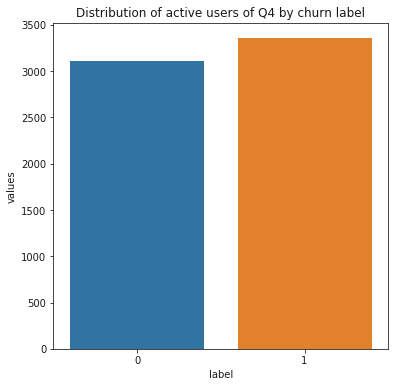

1    3357
0    3108
Name: label, dtype: int64


In [419]:
## We check for any class imbalance in the labelled data set
## Also we check if country code also have an impact on churn
temp = df_model_data["label"].value_counts()
df = pd.DataFrame({'label': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Distribution of active users of Q4 by churn label')
sns.set_color_codes("pastel")
sns.barplot(x = 'label', y="values", data=df)
locs, labels = plt.xticks()
plt.show()
print(temp)

As we can see that the churn and non churn creditors are fairly distributed and hence we need not worry about class imbalance in the dataset

In [420]:
merchant_crosstab = pd.crosstab(df_model_data['label'], df_model_data['merchant_type'], margins=True, normalize=False)
new_index = {1: 'Not-Churned', 0: 'Churned', }
merchant_crosstab.rename(index=new_index,inplace=True)
merchant_crosstab/merchant_crosstab.loc['All']

merchant_type,business,charity,individual,All
label,,,,
Churned,0.425931,0.448852,0.594298,0.47729
Not-Churned,0.574069,0.551148,0.405702,0.52271
All,1.000000,1.000000,1.000000,1.00000


In [421]:
logo_crosstab = pd.crosstab(df_model_data['label'], df_model_data['has_logo'], margins=True, normalize=False)
new_index = {1: 'Not-Churned', 0: 'Churned', }
logo_crosstab.rename(index=new_index,inplace=True)
logo_crosstab/logo_crosstab.loc['All']

has_logo,False,True,All
label,,,
Churned,0.520833,0.431857,0.480742
Not-Churned,0.479167,0.568143,0.519258
All,1.000000,1.000000,1.000000


As seen from the two crosstabs we could see that business has the highest amount of retention and creditors with logo also has better retention

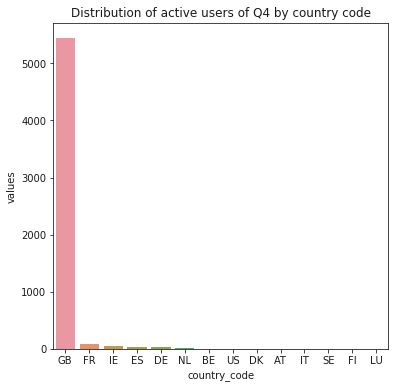

In [422]:
## Also we check if country code also have an impact on churn
temp = df_model_data["country_code"].value_counts()
df = pd.DataFrame({'country_code': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Distribution of active users of Q4 by country code')
sns.set_color_codes("pastel")
sns.barplot(x = 'country_code', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

As we see that GB is the country code we could safely assume that thats not a great feature for seperation of churn and non churn users

Hence we check the WoE and Information value of merchant type and has logo for the labelled data set

In [423]:
# The function to calculate information value
def calc_iv(df, feature, target):

    lst = []

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], 
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]])

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])
    data = data[data['Bad'] > 0]

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE_'+str(feature)] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data['IV_'+str(feature)] = (data['WoE_'+str(feature)] * (data['Distribution Good'] - data['Distribution Bad'])).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)
    
    data=data[['Variable', 'Value','WoE_'+str(feature),'IV_'+str(feature)]]
    data.replace([np.inf, -np.inf], 1,inplace=True)

 
    return (data)

# The function to difference of two lists
def Diff(li1, li2): 
    return (list(set(li1) - set(li2)))

In [424]:
categories=['merchant_type','has_logo']
for category in categories:
    data_out=calc_iv(df_model_data,category,target='label')
    df_model_data=pd.merge(df_model_data,data_out,how='left',left_on=category,right_on='Value')

As we have a labelled data set of all creditors and the WoE and IV of the two categorical variables we now consider the activity pattern for the creditors from Jan 2016 to Sep 2016. If there is any transaction done we flag the month as 1 else 0. 

In [425]:
## Analysing the value and volume transacted by the creditors active in 2016

df_payments_user_total=df_payments.groupby(['creditor_id']).agg({
                                                                    'amount_gbp':'sum',
                                                                    'index':'count',
                                                                    'month':'nunique'
                                                                        }).reset_index()
df_payments_user_total['average_transaction']=df_payments_user_total['amount_gbp']/df_payments_user_total["month"]
df_payments_user_total.columns=['creditor_id','total_vol_tran','total_num_tran','distinct_month_tran','avg_vol_mon']
df_model_data=pd.merge(df_model_data,df_payments_user_total,how='left',left_on='id',right_on='creditor_id')
df_model_data.head()


,index,id,original_id,created_at,has_logo,country_code,merchant_type,refunds_enabled,creditor_id_x,month_x,creditor_id_y,month_y,label,age,Variable_x,Value_x,WoE_merchant_type,IV_merchant_type,Variable_y,Value_y,WoE_has_logo,IV_has_logo,creditor_id,total_vol_tran,total_num_tran,distinct_month_tran,avg_vol_mon
0,0,e86212e4bc9634af,CR00001KBJ97DN,2012-10-10 17:28:18.000000,False,GB,business,False,e86212e4bc9634af,12.0,e86212e4bc9634af,1.0,1,1450,merchant_type,business,-0.207571,0.089236,has_logo,False,0.16045,0.031559,e86212e4bc9634af,3513.38,61.0,12.0,292.781667
1,1,6d6068ca26ce1e22,CR00003KVHNF38,2015-08-10 11:15:35.850315,True,GB,business,False,6d6068ca26ce1e22,12.0,6d6068ca26ce1e22,1.0,1,416,merchant_type,business,-0.207571,0.089236,has_logo,True,-0.19721,0.031559,6d6068ca26ce1e22,3011.08,50.0,11.0,273.734545
2,2,f6410ee29a280622,CR00003SM66ZXX,2015-10-19 10:28:57.401961,True,GB,business,False,f6410ee29a280622,12.0,f6410ee29a280622,1.0,1,346,merchant_type,business,-0.207571,0.089236,has_logo,True,-0.19721,0.031559,f6410ee29a280622,1048.03,52.0,11.0,95.275455
3,3,71df1a1523e4cc85,CR00003SNDMQ4G,2015-10-19 14:19:25.106170,False,GB,individual,False,71df1a1523e4cc85,11.0,71df1a1523e4cc85,1.0,1,346,merchant_type,individual,0.472664,0.089236,has_logo,False,0.16045,0.031559,71df1a1523e4cc85,3859.97,47.0,11.0,350.906364
4,4,e20d37e020a2684f,CR000047GZPHBZ,2016-03-19 13:44:53.916311,False,GB,business,True,e20d37e020a2684f,12.0,e20d37e020a2684f,8.0,1,194,merchant_type,business,-0.207571,0.089236,has_logo,False,0.16045,0.031559,e20d37e020a2684f,10816.06,26.0,5.0,2163.212000


Text(0.5,1,'Density plot by total amount of transaction')

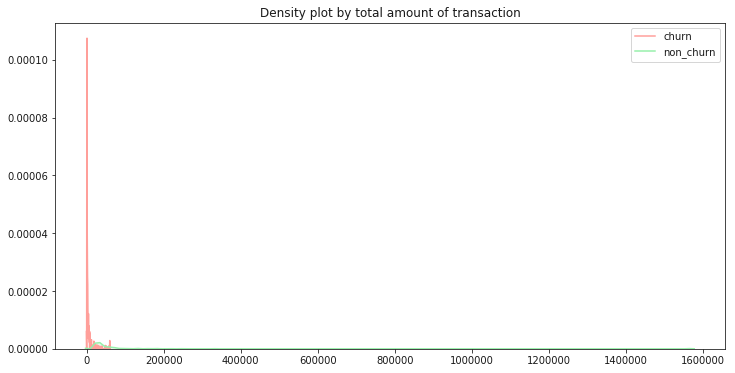

In [426]:
churn = df_model_data[df_model_data["label"] == 0]
non_churn = df_model_data[df_model_data["label"] == 1]
churn["churn"] = churn["total_vol_tran"]
non_churn["non_churn"] = non_churn["total_vol_tran"]
f, ax = plt.subplots(figsize=(12, 6))
ax = sns.kdeplot(churn["churn"], shade=True, color="r")
ax = sns.kdeplot(non_churn["non_churn"], shade=True, color="g")
plt.title('Density plot by total amount of transaction')

Text(0.5,1,'Density plot by no of distinct transaction month')

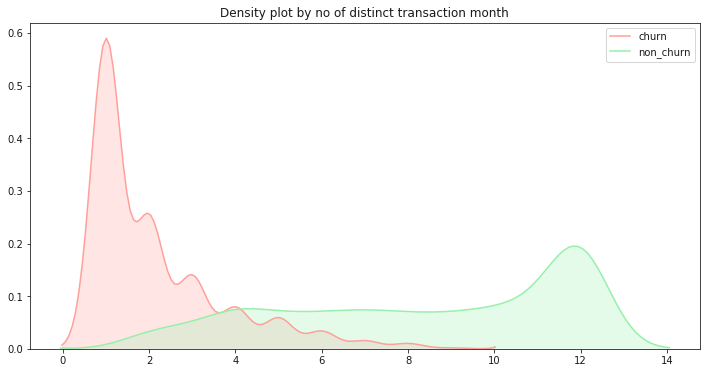

In [427]:
churn = df_model_data[df_model_data["label"] == 0]
non_churn = df_model_data[df_model_data["label"] == 1]
churn["churn"] = churn["distinct_month_tran"]
non_churn["non_churn"] = non_churn["distinct_month_tran"]
f, ax = plt.subplots(figsize=(12, 6))
ax = sns.kdeplot(churn["churn"], shade=True, color="r")
ax = sns.kdeplot(non_churn["non_churn"], shade=True, color="g")
plt.title('Density plot by no of distinct transaction month')

Text(0.5,1,'Density plot by total number of transactions')

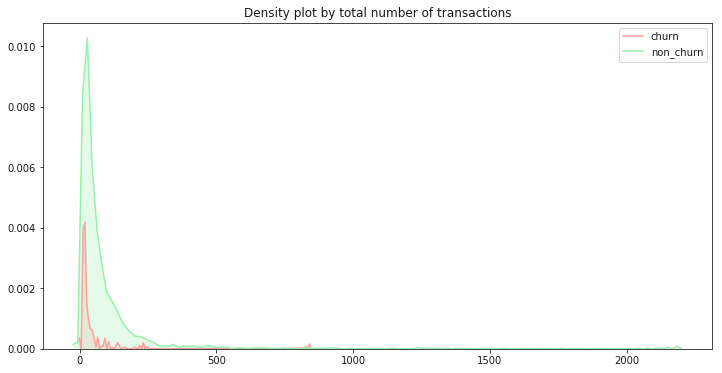

In [428]:
churn = df_model_data[df_model_data["label"] == 0]
non_churn = df_model_data[df_model_data["label"] == 1]
churn["churn"] = churn["total_num_tran"]
non_churn["non_churn"] = non_churn["total_num_tran"]
f, ax = plt.subplots(figsize=(12, 6))
ax = sns.kdeplot(churn["churn"], shade=True, color="r")
ax = sns.kdeplot(non_churn["non_churn"], shade=True, color="g")
plt.title('Density plot by total number of transactions')

Text(0.5,1,'Density plot by average amount of transaction')

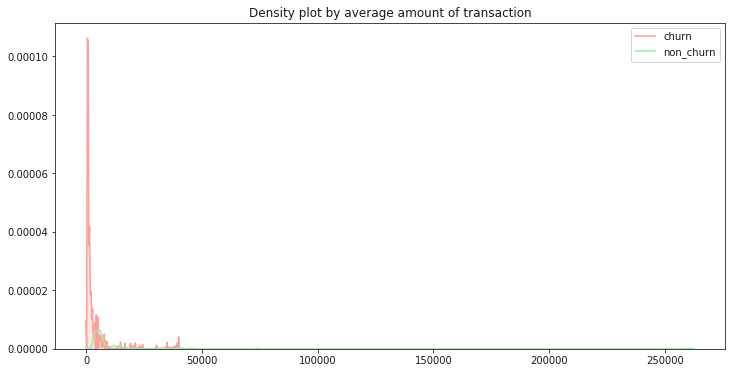

In [429]:
churn = df_model_data[df_model_data["label"] == 0]
non_churn = df_model_data[df_model_data["label"] == 1]
churn["churn"] = churn["avg_vol_mon"]
non_churn["non_churn"] = non_churn["avg_vol_mon"]
f, ax = plt.subplots(figsize=(12, 6))
ax = sns.kdeplot(churn["churn"], shade=True, color="r")
ax = sns.kdeplot(non_churn["non_churn"], shade=True, color="g")
plt.title('Density plot by average amount of transaction')

Text(0.5,1,'Density plot by age of creditors')

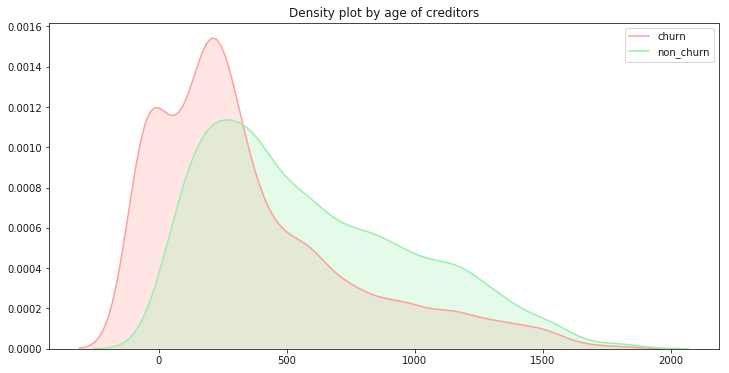

In [430]:
churn = df_model_data[df_model_data["label"] == 0]
non_churn = df_model_data[df_model_data["label"] == 1]
churn["churn"] = churn["age"]
non_churn["non_churn"] = non_churn["age"]
f, ax = plt.subplots(figsize=(12, 6))
ax = sns.kdeplot(churn["churn"], shade=True, color="r")
ax = sns.kdeplot(non_churn["non_churn"], shade=True, color="g")
plt.title('Density plot by age of creditors')

From the 5 density plot we could see the following things:
1. Users with more number of transaction tend to churn less
2. Users with low overall and average transaction by amount tends to churn more
3. Users with less no of distinct months they are active tends to churn more.
4. Users with low age has a peak in churn showing lower age and less activity might be a factor to churn. However there are 339 new users who joined the system on or after OCT 2016 and hence age as a feature would result in penalising them for being new which might skew the prediction. Hence we will not use age as a feature for this model
5. However in case we had more data we could have learnt two models seperately for new as well as old users.

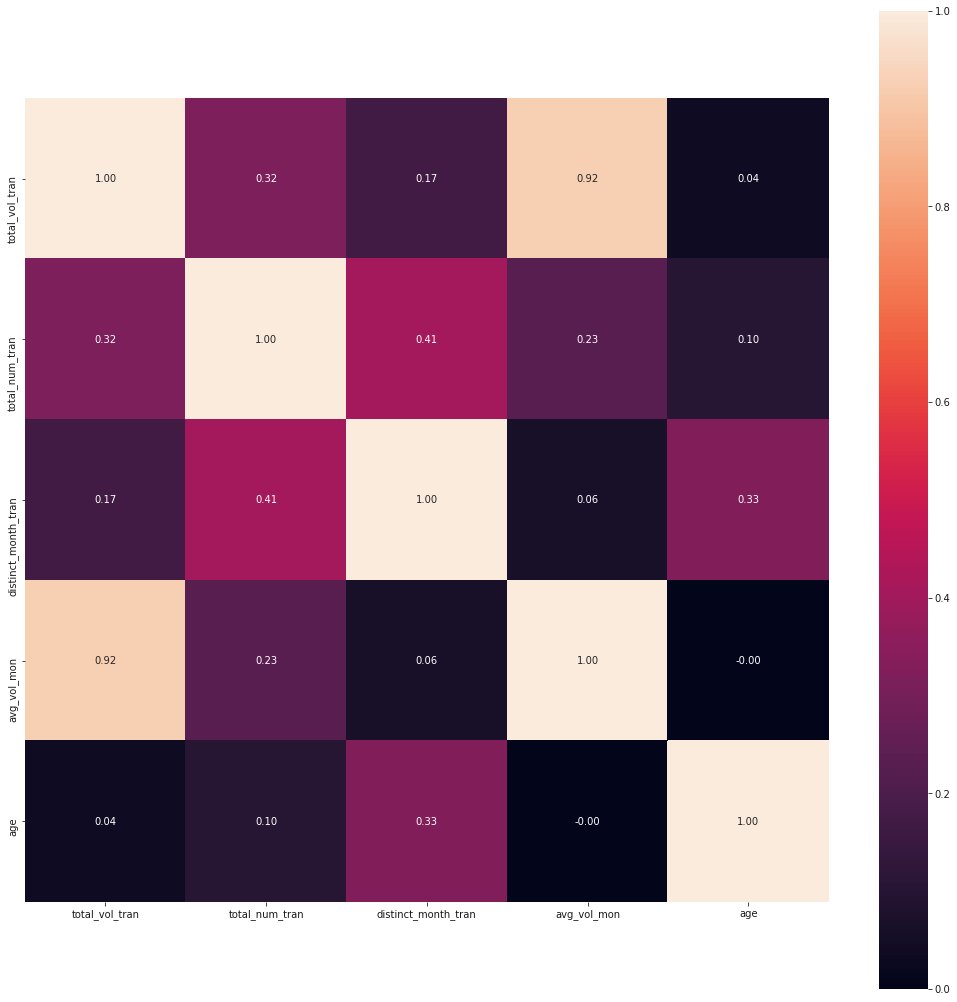

In [431]:
# We see the correlation between the 4 numeric variables in this heat map cross correlation plot
cor = df_model_data[['total_vol_tran','total_num_tran','distinct_month_tran','avg_vol_mon','age']].corr()
plt.figure(figsize=(18,18))
sns.heatmap(cor, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
            xticklabels=cor.columns.values,
            yticklabels=cor.columns.values)

We could see a 0.92 correlation factor between **avg_vol_tran** and **total_vol_tran** and hence we will use **avg_vol_tran**. Also we use **total_num_tran** as another numeric feature since **distinct_month_tran** is used a converted feature of active activities as shown in the next step

In [432]:
## To create the data set we create an arrays of 1 and 0 for creditors based on their active month of usage. 
## Example if a user is active in march and april the out put will be [0,0,1,1,0,0,0,0,0] till Sept 2016

df_creditor_activity=pd.DataFrame()
for creditor in df_model_data.id.unique():
    overall_activity=[1,2,3,4,5,6,7,8,9]
    df_activity=df_payments[(df_payments.creditor_id==creditor)]
    df_activity=df_activity[df_activity.month<=9]
    amount_tran=np.mean(df_activity.amount_gbp)
    num_tran=len(df_activity)
    active_months=df_activity.month.unique()
    no_actvity=Diff(overall_activity,active_months)
    for i in no_actvity:
        if i in overall_activity:
            x=overall_activity.index(i)
            overall_activity[x]=0
    overall_activity = [1 if x>0 else x for x in overall_activity]
    temp=({'creditor':creditor,'active':overall_activity,'amount_tran':amount_tran,'num_tran':num_tran})
    df_creditor_activity=df_creditor_activity.append(temp,ignore_index=True)

In [433]:
df_model_data=pd.merge(df_model_data,df_creditor_activity,how='left',left_on='id',right_on='creditor')

In [434]:
## We create the dataset to run our models 
y=df_model_data.label
x=df_model_data[['active','WoE_merchant_type','IV_merchant_type','WoE_has_logo','IV_has_logo','amount_tran','num_tran']]
z=x['active'].apply(pd.Series)
x = x.merge(z, how='outer', left_index=True, right_index=True)
x=x.drop(['active'],axis = 1)

## We now scale the numeric variables used in the dataset 

print(nulldata(x))

                   Total    Percent
amount_tran         1023  15.823666
IV_merchant_type      58   0.897138
WoE_merchant_type     58   0.897138
8                      0   0.000000
7                      0   0.000000
6                      0   0.000000
5                      0   0.000000
4                      0   0.000000
3                      0   0.000000
2                      0   0.000000
1                      0   0.000000
0                      0   0.000000
num_tran               0   0.000000
IV_has_logo            0   0.000000
WoE_has_logo           0   0.000000


As we see the merchant type has null values we replace them with mode of the entire data set since they are categorical variables. However the amount tran is null for users who were not active through out the last 9 months from Jan 2016 to Sep 2016 and hence replaced by 0

In [435]:
x['amount_tran'].fillna(0, inplace=True)
for column in x.columns:
    x[column].fillna(x[column].mode()[0], inplace=True)

In [436]:
## Now before we use the data in model and create test train we are scaling the two numeric variables
scaler = preprocessing.StandardScaler()
x[['amount_tran','num_tran']]=scaler.fit_transform(x[['amount_tran','num_tran']])
x.head()

,WoE_merchant_type,IV_merchant_type,WoE_has_logo,IV_has_logo,amount_tran,num_tran,0,1,2,3,4,5,6,7,8
0,-0.207571,0.089236,0.16045,0.031559,-0.228076,0.241153,1,1,1,1,1,1,1,1,1
1,-0.207571,0.089236,-0.19721,0.031559,-0.249134,0.052139,1,1,0,1,1,1,1,1,1
2,-0.207571,0.089236,-0.19721,0.031559,-0.318649,-0.001865,1,0,1,1,1,1,1,1,1
3,0.472664,0.089236,0.16045,0.031559,-0.201565,0.119644,1,1,1,1,1,1,1,1,1
4,-0.207571,0.089236,0.16045,0.031559,0.412738,-0.231382,0,0,0,0,0,0,0,1,1


In [437]:
# We divide the dataset in test and train with a split of 70/30
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=2)

In [438]:
# Simultaneously we train 5 supervised learning algorithms and then check their accuracy and F1 score
clfs = {
'LogisticRegression' : LogisticRegression(),
'RandomForest': RandomForestClassifier(),
'DecisionTreeClassifier': DecisionTreeClassifier(),
'GradientBoosting': GradientBoostingClassifier(),
'XGBClassifier': XGBClassifier()
}

In [439]:
models_report = pd.DataFrame(columns = ['Model', 'Precision_score', 'Recall_score','F1_score', 'Accuracy'])

for clf, clf_name in zip(clfs.values(), clfs.keys()):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    y_score = clf.score(x_test,y_test)
    
    #print('Calculating {}'.format(clf_name))
    t = pd.Series({ 
                     'Model': clf_name,
                     'Precision_score': metrics.precision_score(y_test, y_pred),
                     'Recall_score': metrics.recall_score(y_test, y_pred),
                     'F1_score': metrics.f1_score(y_test, y_pred),
                     'Accuracy': metrics.accuracy_score(y_test, y_pred)}
                   )

    models_report = models_report.append(t, ignore_index = True)

models_report

,Model,Precision_score,Recall_score,F1_score,Accuracy
0,LogisticRegression,0.903292,0.871897,0.887317,0.885052
1,RandomForest,0.889458,0.862959,0.876008,0.873196
2,DecisionTreeClassifier,0.844181,0.850050,0.847105,0.840722
3,GradientBoosting,0.900407,0.879841,0.890005,0.887113
4,XGBClassifier,0.904713,0.876862,0.890570,0.888144


Of the 5 models the accuracy is highest in XGBclassifier and also the F1-score which is best hence this model seems to have the best performance of the 5. Hence we will explore and predict further based on the XGBClassifier model

In [440]:
def gridsearch(model, params,x_train, x_test, y_train, y_test, kfold):
    gs = GridSearchCV(model, params, scoring='accuracy', n_jobs=-1, cv=kfold)
    gs.fit(x_train, y_train)
    print ('Best params: ', gs.best_params_)
    print ('Best AUC on Train set: ', gs.best_score_)
    print ('Best AUC on Test set: ', gs.score(x_test, y_test))

# Function to generate confusion matrix
def confmat(pred, y_test):
    conmat = np.array(confusion_matrix(y_test, pred, labels=[1,0]))
    conf = pd.DataFrame(conmat, index=['Not Churn', 'Churn'],
                             columns=['Predicted Not Churn', 'Predicted Churn'])
    print (conf)

# Function to plot roc curve
def roc(prob, y_test):
    y_score = prob
    fpr = dict()
    tpr = dict()
    roc_auc=dict()
    fpr[1], tpr[1], _ = roc_curve(y_test, y_score)
    roc_auc[1] = auc(fpr[1], tpr[1])
    plt.figure(figsize=[7,7])
    plt.plot(fpr[1], tpr[1], label='Roc curve (area=%0.2f)' %roc_auc[1], linewidth=4)
    plt.plot([1,0], [1,0], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive rate', fontsize=15)
    plt.ylabel('True Positive rate', fontsize=15)
    plt.title('ROC curve for Creditor Churn', fontsize=16)
    plt.legend(loc='Lower Right')
    plt.show()
    
def model(md, x_train, y_train,x_test, y_test):
    md.fit(x_train, y_train)
    pred = md.predict(x_test)
    prob = md.predict_proba(x_test)[:,1]
    print (' ') 
    print ('Accuracy on Train set: ', md.score(x_train, y_train))
    print ('Accuracy on Test set: ', md.score(x_test, y_test))
    print (' ')
    print(classification_report(y_test, pred))
    print (' ')
    print ('Confusion Matrix')
    confmat(pred, y_test)
    roc(prob, y_test)
    return pred

### Parameter tuning
There are a few parameters that require tuning to improve the performance. I use GridSearchCV method to test model through a series of parameter values.

In [441]:
xgb = XGBClassifier()
xgb_params = {'n_estimators':[200,300],'learning_rate':[0.05,0.02], 'max_depth':[4],'min_child_weight':[0],'gamma':[0]}
gridsearch(xgb, xgb_params,x_train, x_test, y_train, y_test,5)

Best params:  {'gamma': 0, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 200}
Best AUC on Train set:  0.8844198895027624
Best AUC on Test set:  0.8886597938144329


 
Accuracy on Train set:  0.8956906077348066
Accuracy on Test set:  0.8886597938144329
 
             precision    recall  f1-score   support

          0       0.88      0.89      0.89       933
          1       0.90      0.88      0.89      1007

avg / total       0.89      0.89      0.89      1940

 
Confusion Matrix
           Predicted Not Churn  Predicted Churn
Not Churn                  889              118
Churn                       98              835


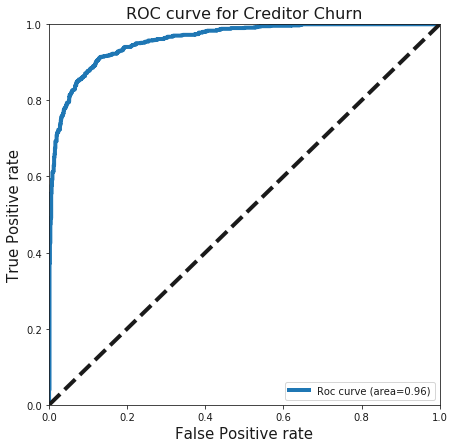

In [442]:
xgb = XGBClassifier(
 learning_rate =0.02,
 n_estimators=200,
 max_depth=4,
 min_child_weight=0,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=1,
 scale_pos_weight=1,
 seed=27)
model_xgb = model(xgb, x_train, y_train,x_test, y_test)

In [443]:
## A psuedo step to get the values in variables
y_pred_prob = xgb.predict_proba(x_test)
y_pred_final= xgb.predict(x_test)

As the XGB classifier is trained we would use it to predict the probability of churn for our new data. The new data is actually the activity of last 9 months starting from April 2016 to Dec 2016 of the 4268 creditors who were active in Q4 2016.

In [444]:
df_creditors_q4=df_creditors[df_creditors.month_x>=10]

In [445]:
df_creditor_activity_new=pd.DataFrame()
for creditor in df_creditors_q4.id.unique():
    overall_activity=[4,5,6,7,8,9,10,11,12]
    df_activity=df_payments[(df_payments.creditor_id==creditor)]
    df_activity=df_activity[df_activity.month>=4]
    amount_tran=np.mean(df_activity.amount_gbp)
    num_tran=len(df_activity)
    active_months=df_activity.month.unique()
    no_actvity=Diff(overall_activity,active_months)
    for i in no_actvity:
        if i in overall_activity:
            x=overall_activity.index(i)
            overall_activity[x]=0
    overall_activity = [1 if x>0 else x for x in overall_activity]
    temp=({'creditor':creditor,'active_new':overall_activity,'amount_tran':amount_tran,'num_tran':num_tran})
    df_creditor_activity_new=df_creditor_activity_new.append(temp,ignore_index=True)

In [446]:
df_creditors_new=pd.merge(df_creditors_q4,df_creditor_activity_new,how='left',left_on='id',right_on='creditor')
df_creditors_new['age']=df_creditors_new.apply(lambda row:(datetime.datetime.strptime('2016-12-31 00:00:00','%Y-%m-%d %H:%M:%S')-row.created_at).days,axis=1)                                      

df_creditors_new.head()

,index,id,original_id,created_at,has_logo,country_code,merchant_type,refunds_enabled,creditor_id_x,month_x,creditor_id_y,month_y,active_new,amount_tran,creditor,num_tran,age
0,0,e86212e4bc9634af,CR00001KBJ97DN,2012-10-10 17:28:18.000000,False,GB,business,False,e86212e4bc9634af,12.0,e86212e4bc9634af,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",55.077234,e86212e4bc9634af,47.0,1542
1,1,6d6068ca26ce1e22,CR00003KVHNF38,2015-08-10 11:15:35.850315,True,GB,business,False,6d6068ca26ce1e22,12.0,6d6068ca26ce1e22,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",62.215000,6d6068ca26ce1e22,48.0,508
2,2,f6410ee29a280622,CR00003SM66ZXX,2015-10-19 10:28:57.401961,True,GB,business,False,f6410ee29a280622,12.0,f6410ee29a280622,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",20.289600,f6410ee29a280622,50.0,438
3,3,71df1a1523e4cc85,CR00003SNDMQ4G,2015-10-19 14:19:25.106170,False,GB,individual,False,71df1a1523e4cc85,11.0,71df1a1523e4cc85,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 0]",80.354500,71df1a1523e4cc85,40.0,438
4,4,e20d37e020a2684f,CR000047GZPHBZ,2016-03-19 13:44:53.916311,False,GB,business,True,e20d37e020a2684f,12.0,e20d37e020a2684f,8.0,"[0, 0, 0, 0, 1, 1, 1, 1, 1]",416.002308,e20d37e020a2684f,26.0,286


In [447]:
categories=['merchant_type','has_logo']
for category in categories:
    data_out=calc_iv(df_model_data,category,target='label')
    df_creditors_new=pd.merge(df_creditors_new,data_out,how='left',left_on=category,right_on='Value')

In [448]:
x_new=df_creditors_new[['active_new','WoE_merchant_type','IV_merchant_type','WoE_has_logo','IV_has_logo','amount_tran','num_tran']]
z=x_new['active_new'].apply(pd.Series)
x_new = x_new.merge(z, how='outer', left_index=True, right_index=True)
x_new=x_new.drop(['active_new'],axis = 1)
x_new[['amount_tran','num_tran']]=scaler.fit_transform(x_new[['amount_tran','num_tran']])
for column in x_new.columns:
    x_new[column].fillna(x_new[column].mode()[0], inplace=True)
print(nulldata(x_new))

                   Total  Percent
8                      0      0.0
7                      0      0.0
6                      0      0.0
5                      0      0.0
4                      0      0.0
3                      0      0.0
2                      0      0.0
1                      0      0.0
0                      0      0.0
num_tran               0      0.0
amount_tran            0      0.0
IV_has_logo            0      0.0
WoE_has_logo           0      0.0
IV_merchant_type       0      0.0
WoE_merchant_type      0      0.0


In [449]:
final_pred_q4=xgb.predict(x_new)
final_pred_prob_q4=xgb.predict_proba(x_new)[:,1]

In [450]:
np.unique(final_pred_q4, return_counts=True)

(array([0, 1]), array([1611, 2657]))

In [451]:
df_creditors_new['pred_prob']=final_pred_prob_q4

In [452]:
df_creditors_final=df_creditors_new[['id','pred_prob']]

In [453]:
df_creditors_final.to_csv('df_creditors_final_2.csv')

Since we obtain the probability of churn with lower value defining higher chance of churn we can bucket the users based on their probabilities of churn and then take actions accordingly

In [454]:
bins = [0, .25, .5, .75, 1]
groups = df_creditors_final.groupby(pd.cut(df_creditors_final.pred_prob, bins))
groups.id.count()

pred_prob
(0.0, 0.25]     854
(0.25, 0.5]     757
(0.5, 0.75]     607
(0.75, 1.0]    2050
Name: id, dtype: int64

As we can see that there are 1611 users who has high probability of churn but there is also 607 users who are borderline as they have less than 75% probability of being retained and hence the campaign should target them also

In [455]:
## Saving the model files to be used later

## Store the models and scalar values as pickles
import pickle
pkl_filename = "pickle_predict_model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(xgb, file)

pkl_scaler_file = "pickle_scaler.pkl"  
with open(pkl_scaler_file, 'wb') as file:  
    pickle.dump(scaler, file)

pkl_data_frame="pickle_new_data.pkl"
with open(pkl_data_frame, 'wb') as file:  
    pickle.dump(df_creditors_new, file)

    
    


### The steps to import pickle and do the same prediction as done above with out running the entire code

1. We import all the pickle files
2. Do the basic data transformation
3. Predict using the loaded pickle model
4. Get the output same as shown above

In [456]:
## Initialize the libraries
import psycopg2
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import preprocessing, metrics
from xgboost import XGBClassifier
import warnings
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load the files

pkl_filename = "pickle_predict_model.pkl"
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file)
    
pkl_scaler_file = "pickle_scaler.pkl"
with open(pkl_scaler_file, 'rb') as file:  
    pickle_scaler = pickle.load(file)
    
pkl_data_frame="pickle_new_data.pkl"
with open(pkl_data_frame, 'rb') as file:  
    pickle_data = pickle.load(file)

    
x_new=pickle_data[['active_new','WoE_merchant_type','IV_merchant_type','WoE_has_logo','IV_has_logo','amount_tran','num_tran']]
z=x_new['active_new'].apply(pd.Series)
x_new = x_new.merge(z, how='outer', left_index=True, right_index=True)
x_new=x_new.drop(['active_new'],axis = 1)
x_new[['amount_tran','num_tran']]=pickle_scaler.fit_transform(x_new[['amount_tran','num_tran']])
for column in x_new.columns:
    x_new[column].fillna(x_new[column].mode()[0], inplace=True)
print(nulldata(x_new))


final_pred_q4=pickle_model.predict(x_new)
final_pred_prob_q4=pickle_model.predict_proba(x_new)[:,1]
np.unique(final_pred_q4, return_counts=True)

pickle_data['pred_prob']=final_pred_prob_q4

df_creditors_final=pickle_data[['id','pred_prob']]
df_creditors_final.to_csv('df_creditors_final_output.csv')


                   Total  Percent
8                      0      0.0
7                      0      0.0
6                      0      0.0
5                      0      0.0
4                      0      0.0
3                      0      0.0
2                      0      0.0
1                      0      0.0
0                      0      0.0
num_tran               0      0.0
amount_tran            0      0.0
IV_has_logo            0      0.0
WoE_has_logo           0      0.0
IV_merchant_type       0      0.0
WoE_merchant_type      0      0.0


In [ ]:
URL = "https://cdn-api.co-vin.in/api/v2/appointment/sessions/public/calendarByDistrict?district_id={}&date={}"

In [ ]:
requests.get(URL.format("294", "04/05/2021"))

In [3]:
!pip3 install pandas

  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 9.5MB 198kB/s eta 0:00:01    98% |███████████████████████████████▌| 9.4MB 23.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 512kB 3.2MB/s eta 0:00:01
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 13.4MB 138kB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d9/5a/e7c31adbe875f2abbb91bd84cf2dc52d792b5a01506781dbcf25c91daf11/six-1.16.0-py2.py3-none-any.whl
